In [2]:
import time
import math
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

## Loading data Pandas vs Polars

In [3]:
# Load data (polars)
t1 = time.time()

# Try parse dates checks for date columns and sets data type to datetime while loading data
users_pl = pl.read_csv('Data/users.csv', try_parse_dates=True)
weights_pl = pl.read_csv('Data/weights.csv', try_parse_dates=True)
treatments_pl = pl.read_csv('Data/treatments.csv', try_parse_dates=True)

t2 = time.time()
po = t2-t1
print('Time taken to load polars datasets ', po)

Time taken to load polars datasets  0.032996177673339844


In [4]:
# Load data (pandas)
t1 = time.time()
users = pd.read_csv('Data/users.csv')
weights = pd.read_csv('Data/weights.csv')
treatments = pd.read_csv('Data/treatments.csv')
t2 = time.time()
pa = t2 - t1
print('Time taken to load datasets ', pa)

Time taken to load datasets  0.06560397148132324


Text(0.5, 1.0, 'Time taken to load datasets')

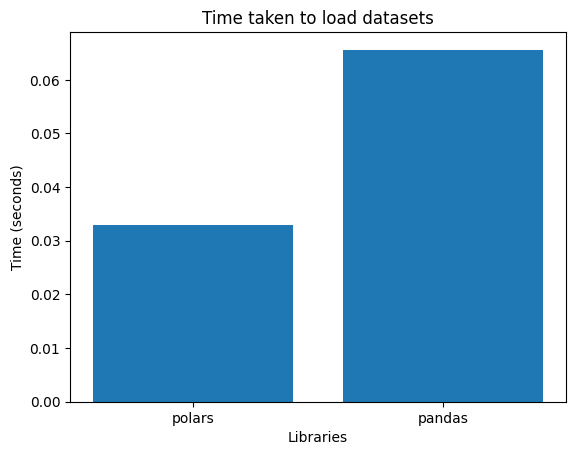

In [7]:
plt.bar(['polars', 'pandas'], [po, pa])
plt.xlabel('Libraries')
plt.ylabel('Time (seconds)')
plt.title('Time taken to load datasets')

## Merging datasets

In [10]:
# Left join dataframes: Users <> Weights, Treatments (polars)
t1= time.time()

uw = users_pl.join(weights_pl, left_on='UID',
                right_on='MasterUserID',
                how='left')
merged_pl = uw.join(treatments_pl,
                    left_on='UID', right_on='MasterUserID',
                    how='left')

t2 = time.time()
po = t2-t1
print('Time taken to merge datasets ', po)

Time taken to merge datasets  0.009722232818603516


In [11]:
# Left join dataframes: Users <> Weights, Treatments
t1= time.time()

uw = pd.merge(users, weights,
              left_on='UID', right_on='MasterUserID',
              how='left')
merged_df = pd.merge(uw, treatments,
                     left_on='UID', right_on='MasterUserID',
                     how='left')

t2 = time.time()
pa = t2-t1
print('Time taken to merge datasets ', pa)

Time taken to merge datasets  0.03625082969665527


Text(0.5, 1.0, 'Time taken to merge datasets')

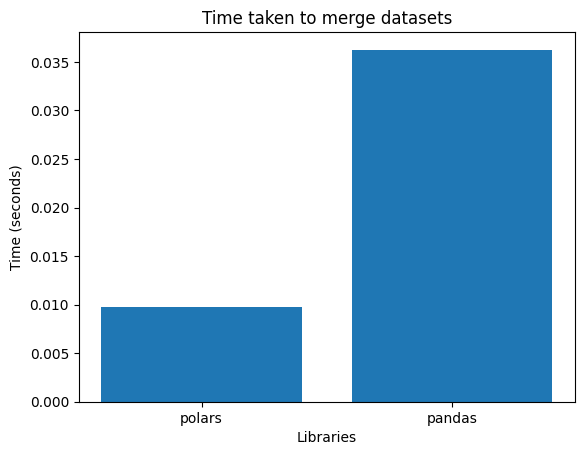

In [12]:
plt.bar(['polars', 'pandas'], [po, pa])
plt.xlabel('Libraries')
plt.ylabel('Time (seconds)')
plt.title('Time taken to merge datasets')

## Rename columns

### Pandas vs Polars (dropping duplicates)

Pandas - does not drop the columns it is merged on creating duplicate columns

Polars - drops the duplicate columns while joining

In [13]:
# Rename columns for better understanding (polars)
columns_to_rename = {'CreatedDate': 'UIDCreatedDate',
                     'IsActive': 'User_IsActive',
                     'CreatedDate_right': 'Weights_CreatedDate',
                     'UpdatedDate': 'Weights_UpdatedDate',
                     'IsActive_right': 'Weights_IsActive',
                     'IsDelete': 'Weights_IsDelete',
                     'StartDate': 'Treatment_StartDate',
                     }
merged_pl = merged_pl.rename(columns_to_rename)

# Drop duplicates (pandas)
merged_df = merged_df.drop(columns=['MasterUserID_x', 'MasterUserID_y'])

# Rename columns for better understanding (pandas)
columns_to_rename = {'CreatedDate_x': 'UIDCreatedDate',
                     'IsActive_x': 'User_IsActive',
                     'CreatedDate_y': 'Weights_CreatedDate',
                     'UpdatedDate': 'Weights_UpdatedDate',
                     'IsActive_y': 'Weights_IsActive',
                     'IsDelete': 'Weights_IsDelete',
                     'StartDate': 'Treatment_StartDate',
                     }
merged_df = merged_df.rename(columns=columns_to_rename)

## Sorting the data

In [14]:
# Sort by 'UID', 'UIDCreatedDate', 'TreatmentTypeID', 'Treatment_StartDate',
# 'Weights_CreatedDate', 'Weights_UpdatedDate' (polars)
t1 = time.time()

merged_pl = merged_pl.sort(by=['UID',
                               'UIDCreatedDate',
                               'TreatmentTypeID',
                               'Treatment_StartDate',
                               'Weights_CreatedDate',
                               'Weights_UpdatedDate'])


t2 = time.time()
po = t2 - t1
print('Time taken to sort dataset ', po)

Time taken to sort dataset  0.012112140655517578


### Pandas vs Polars (parsing date columns)

Pandas - Parses date columns when you specify the column names during data loading

Polars - Automatically detects datetime columns and changes dataa type while loading

In [15]:
# Change datatypes of date columns from object to date (pandas)
columns_to_change = ['Birthday', 'UIDCreatedDate', 'Weights_CreatedDate',
                     'Weights_UpdatedDate', 'Treatment_StartDate']

merged_df[columns_to_change] = merged_df[columns_to_change].apply(pd.to_datetime)

# Sort by 'UID', 'UIDCreatedDate', 'TreatmentTypeID', 'Treatment_StartDate',
# 'Weights_CreatedDate', 'Weights_UpdatedDate' (pandas)
t1 = time.time()

merged_df = merged_df.sort_values(by=['UID',
                                      'UIDCreatedDate',
                                      'TreatmentTypeID',
                                      'Treatment_StartDate',
                                      'Weights_CreatedDate',
                                      'Weights_UpdatedDate'])


t2 = time.time()
pa = t2-t1
print('Time taken to sort dataset ', pa)

Time taken to sort dataset  0.01755499839782715


Text(0.5, 1.0, 'Time taken to sort datasets')

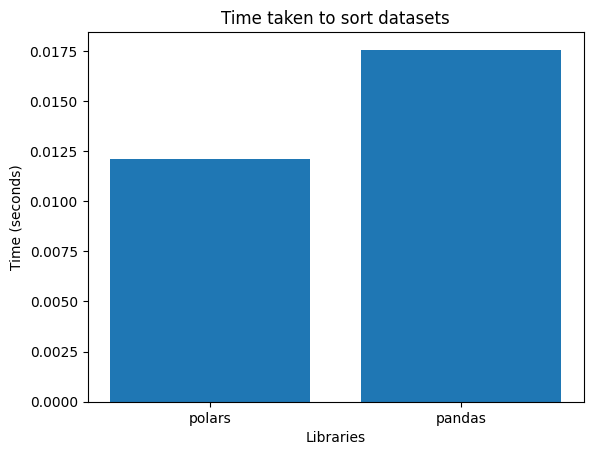

In [19]:
plt.bar(['polars', 'pandas'], [po, pa])
plt.xlabel('Libraries')
plt.ylabel('Time (seconds)')
plt.title('Time taken to sort datasets')

## Data pipeline + Filter 

In [17]:
# (Polars)
def filters_pl(df, gender='all', min_age=18, max_age=72, ClinicID=5066):
    """
    :params df(DataFrame): Pandas dataframe to filter
    :params gender (str): Gender of the user; 'Male' or 'Female' or 'all'
    :params min_age (int): Minimum age of the user to be queried
    :params max_age (int): Maximum age of the user to be queried
    :params ClinicID (int): ClinicID of the clinic that the users go to
    
    Filters the data (df) based on Gender, Age and Clinic
    """
    
    # Gender filter
    if gender == 'all':
        df = df
    elif gender == 'Male':
        df = df.filter(pl.col('Gender') == 'Male')
    elif gender == 'Female':
        df = df.filter(pl.col('Gender') == 'Female')
        
    # Age filter
    # Set min_age and max_age same if you want users of a specific age
    # Change min_age and max_age to get users between a certain age
    df = df.filter((pl.col('Age') >= min_age) & (pl.col('Age') <= max_age))
    
    # Clinic filter
    df = df.filter(pl.col('ClinicID') == ClinicID)
    
    return df

def data_pipeline_pl(path_to_data, cohort='week', gender='all',
                  min_age=18, max_age=72, ClinicID=5066):
    """
    :params path_to_data (str): Path to data
    :params cohort (str): To get info monthly, weekly and based on clinic
    :params gender (str): Gender of the user; 'Male' or 'Female' or 'all'
    :params min_age (int): Minimum age of the user to be queried
    :params max_age (int): Maximum age of the user to be queried
    :params ClinicID (int): ClinicID of the clinic that the users go to
    
    Loads dataset, merges them, cleans them, calculates required metrics,
    and returns a dataframe with the 'weigh_in_rate', 'patient_starting_weight',
    'treatment_starting_weight', 'treatment_TBWL', 'patient_TBWL' metrics for each user cohort wise
    """
    
    # Load datasets
    users = pl.read_csv(f'{path_to_data}/users.csv', try_parse_dates=True)
    weights = pl.read_csv(f'{path_to_data}/weights.csv', try_parse_dates=True)
    treatments = pl.read_csv(f'{path_to_data}/treatments.csv', try_parse_dates=True)
    
    
    # Left join dataframes: Users <> Weights, Treatments
    uw = users.join(weights, left_on='UID',
                    right_on='MasterUserID',
                    how='left')
    merged_df = uw.join(treatments,
                        left_on='UID', right_on='MasterUserID',
                        how='left')
    
    
    # Rename columns for better understanding
    columns_to_rename = {'CreatedDate': 'UIDCreatedDate',
                         'IsActive': 'User_IsActive',
                         'CreatedDate_right': 'Weights_CreatedDate',
                         'UpdatedDate': 'Weights_UpdatedDate',
                         'IsActive_right': 'Weights_IsActive',
                         'IsDelete': 'Weights_IsDelete',
                         'StartDate': 'Treatment_StartDate',
                         }
    merged_df = merged_df.rename(columns_to_rename)
    
    
    # Sort the data by 'UID', 'UIDCreatedDate', 'TreatmentTypeID', 'Treatment_StartDate',
    # 'Weights_CreatedDate', 'Weights_UpdatedDate'
    merged_df = merged_df.sort(by=['UID',
                                   'UIDCreatedDate',
                                   'TreatmentTypeID',
                                   'Treatment_StartDate',
                                   'Weights_CreatedDate',
                                   'Weights_UpdatedDate'])

    
    # The difference between the treatment start date and the weights created/updated 
    # can be used to calculate the month/week from the start of the treatment
    # Starting from week/month 1 i.e., first week of treatment instead of zeroth week

    merged_df = merged_df.with_columns(days_in_month=pl.lit(30.417))
    merged_df = merged_df.with_columns(days_in_week=pl.lit(7))

    merged_df = merged_df.with_columns((pl.col('Weights_CreatedDate') - pl.col('Treatment_StartDate')).alias('datediff'))

    # Calculate the number of months since treatment start date
    merged_df = merged_df.with_columns(((pl.col('datediff') / pl.duration(days="days_in_month")).floor()).alias('month'))

    # Calculate the number of weeks since treatment start date
    merged_df = merged_df.with_columns(((pl.col('datediff') / pl.duration(days="days_in_week")).floor()).alias('week'))
    
    # Cast float to int
    merged_df = merged_df.with_columns(pl.col('month').cast(pl.Int32), pl.col('week').cast(pl.Int32))
    
    # weigh-in rate - number of times a user has weighed themselves during each week/month of treatment

    # Why treatment start date? - Ex- The user might have been in Trt 1 first, switched to Trt 2 and back to 1

    merged_df = merged_df.with_columns(pl.col('Weights_UpdatedDate').count().over(['UID', 
                                                                               'TreatmentTypeID',
                                                                               'Treatment_StartDate',
                                                                               'week']).alias('weigh_in_rate'))
    
    
    # Patient starting weight
    merged_df = merged_df.with_columns(pl.col('Weight').first().over('UID').alias('patient_starting_weight'))
    
    
    # Treatment starting weight
    merged_df = merged_df.with_columns(pl.col('Weight').first().over(['UID', 'TreatmentTypeID',
                                                      'Treatment_StartDate']).alias('treatment_starting_weight'))

    
    # Treatment total body weight loss

    # The differene between the patient weight at the start of the treatment
    # and the patient weight at the end of the treatment

    # Treatment ending weight
    merged_df = merged_df.with_columns(pl.col('Weight').last().over(['UID', 'TreatmentTypeID',
                                                          'Treatment_StartDate']).alias('treatment_ending_weight'))

    # Difference between treatment ending weight and starting weight
    merged_df = merged_df.with_columns((pl.col('treatment_ending_weight') - pl.col('treatment_starting_weight')).\
                                       alias('treatment_TBWL'))
    
    
    # Patient total body weight loss

    # The difference between patient weight at the start of the cohort (week/month)
    # and patient weight at the start of the next cohort (week/month)

    # Find the weight at the start of eahc week and calculate the consecutive row differences
    merged_df = merged_df.with_columns(pl.col('Weight').first().over(['UID', 'TreatmentTypeID',
                                                                   'Treatment_StartDate',
                                                                   'week']).alias('wgt_diff').diff(-1))

    # Weight lost each week is the highest wgt_diff each week
    merged_df = merged_df.with_columns(pl.col('wgt_diff').max().over(['UID', 'TreatmentTypeID',
                                                          'Treatment_StartDate',
                                                          'week']).alias('patient_TBWL'))

    # Drop wgt_diff column
    merged_df = merged_df.drop(columns=['wgt_diff', 'days_in_month', 'days_in_week', 'datediff'])
    
    # Filter
    merged_df = filters_pl(merged_df, gender, min_age, max_age, ClinicID)
    
    
    return merged_df

In [18]:
# Pandas
def filters_pd(df, gender='all', min_age=18, max_age=72, ClinicID=5066):
    """
    :params df(DataFrame): Pandas dataframe to filter
    :params gender (str): Gender of the user; 'Male' or 'Female' or 'all'
    :params min_age (int): Minimum age of the user to be queried
    :params max_age (int): Maximum age of the user to be queried
    :params ClinicID (int): ClinicID of the clinic that the users go to
    
    Filters the data (df) based on Gender, Age and Clinic
    """
    
    # Gender filter
    if gender == 'all':
        df = df
    elif gender == 'Male':
        df = df[df.Gender == 'Male']
    elif gender == 'Female':
        df = df[df.Gender == 'Female']
        
    # Age filter
    # Set min_age and max_age same if you want users of a specific age
    # Change min_age and max_age to get users between a certain age
    df = df[(df.Age >= min_age) & (df.Age <= max_age)]
    
    # Clinic filter
    df = df[df.ClinicID == ClinicID]
    
    return df

def data_pipeline_pd(path_to_data, cohort='week', gender='all',
                  min_age=18, max_age=72, ClinicID=5066):
    """
    :params path_to_data (str): Path to data
    :params cohort (str): To get info monthly, weekly and based on clinic
    :params gender (str): Gender of the user; 'Male' or 'Female' or 'all'
    :params min_age (int): Minimum age of the user to be queried
    :params max_age (int): Maximum age of the user to be queried
    :params ClinicID (int): ClinicID of the clinic that the users go to
    
    Loads dataset, merges them, cleans them, calculates required metrics,
    and returns a dataframe with the 'weigh_in_rate', 'patient_starting_weight',
    'treatment_starting_weight', 'treatment_TBWL', 'patient_TBWL' metrics for each user cohort wise
    """
    
    # Load datasets
    users = pd.read_csv(f'{path_to_data}/users.csv')
    weights = pd.read_csv(f'{path_to_data}/weights.csv')
    treatments = pd.read_csv(f'{path_to_data}/treatments.csv')
    
    
    # Left join dataframes: Users <> Weights, Treatments
    uw = pd.merge(users, weights,
                  left_on='UID', right_on='MasterUserID',
                  how='left')
    merged_df = pd.merge(uw, treatments,
                         left_on='UID', right_on='MasterUserID',
                         how='left')
    
    
    # Drop 2 duplicate UserID columns as the values are same in the 2 columns and UID column
    merged_df = merged_df.drop(columns=['MasterUserID_x', 'MasterUserID_y'])
    
    
    # Rename columns for better understanding
    columns_to_rename = {'CreatedDate_x': 'UIDCreatedDate',
                         'IsActive_x': 'User_IsActive',
                         'CreatedDate_y': 'Weights_CreatedDate',
                         'UpdatedDate': 'Weights_UpdatedDate',
                         'IsActive_y': 'Weights_IsActive',
                         'IsDelete': 'Weights_IsDelete',
                         'StartDate': 'Treatment_StartDate',
                         }
    merged_df = merged_df.rename(columns=columns_to_rename)
    
    
    # Change datatypes of date columns from object to date
    columns_to_change = ['Birthday', 'UIDCreatedDate', 'Weights_CreatedDate',
                         'Weights_UpdatedDate', 'Treatment_StartDate']

    merged_df[columns_to_change] = merged_df[columns_to_change].apply(pd.to_datetime)
    
    
    # Sort the data by 'UID', 'UIDCreatedDate', 'TreatmentTypeID', 'Treatment_StartDate',
    # 'Weights_CreatedDate', 'Weights_UpdatedDate'
    merged_df = merged_df.sort_values(by=['UID',
                                          'UIDCreatedDate',
                                          'TreatmentTypeID',
                                          'Treatment_StartDate',
                                          'Weights_CreatedDate',
                                          'Weights_UpdatedDate'])
    
    
    # The difference between the treatment start date and the weights created/updated 
    # can be used to calculate the month/week from the start of the treatment
    # Starting from week/month 1 i.e., first week of treatment instead of zeroth week

    # Calculate the number of months since treatment start date
    merged_df['month'] = (merged_df['Weights_CreatedDate'] - merged_df['Treatment_StartDate']).dt.days / 30.44
    merged_df['month'] = merged_df['month'].apply(math.floor)

    # Calculate the number of weeks since treatment start date
    merged_df['week'] = (merged_df['Weights_CreatedDate'] - merged_df['Treatment_StartDate']).dt.days / 7
    merged_df['week'] = merged_df['week'].apply(math.floor)
    
    
    # weigh-in rate - number of times a user has weighed themselves during each week/month of treatment

    # Why treatment start date? - Ex- The user might have been in Trt 1 first, switched to Trt 2 and back to 1

    merged_df['weigh_in_rate'] = merged_df.groupby(['UID', 
                                                    'TreatmentTypeID',
                                                    'Treatment_StartDate',
                                                    cohort])['Weights_UpdatedDate'].transform('count')
    
    
    # Patient starting weight
    merged_df['patient_starting_weight'] = merged_df.groupby(['UID'])['Weight'].transform('first')
    
    
    # Treatment starting weight
    merged_df['treatment_starting_weight'] = merged_df.groupby(['UID',
                                                                'TreatmentTypeID',
                                                                'Treatment_StartDate'])['Weight'].transform('first')
    
    
    # Treatment total body weight loss

    # The differene between the patient weight at the start of the treatment
    # and the patient weight at the end of the treatment

    # Treatment ending weight
    tew = merged_df.groupby(['UID',
                             'TreatmentTypeID',
                             'Treatment_StartDate'])['Weight'].transform('last')

    merged_df['treatment_TBWL'] = tew - merged_df['treatment_starting_weight']
    
    
    # Patient total body weight loss

    # The difference between patient weight at the start of the cohort (week/month)
    # and patient weight at the start of the next cohort (week/month)

    merged_df['wgt_diff'] = merged_df.groupby(['UID',
                                               'TreatmentTypeID',
                                               'Treatment_StartDate',
                                               cohort])['Weight'].transform('first').diff(-1)

    # Replace with same cohort_wise weight loss for the respective user cohorts
    merged_df['patient_TBWL'] = merged_df.groupby(['UID',
                                                   'TreatmentTypeID',
                                                   'Treatment_StartDate',
                                                   cohort])['wgt_diff'].transform('max')
    # Drop wgt_diff column
    merged_df = merged_df.drop(columns=['wgt_diff'])
    
    
    # Filter
    merged_df = filters_pd(merged_df, gender, min_age, max_age, ClinicID)
    
    
    return merged_df

In [20]:
# Polars
t1 = time.time()
data_pipeline_pl('Data/', gender='Male', max_age=18)
t2 = time.time()

po = t2 - t1
print('Time taken to execute data pipeline using polars ', po)

Time taken to execute data pipeline using polars  0.05180025100708008


In [21]:
# Pandas
t1 = time.time()
data_pipeline_pd('Data/', gender='Male', max_age=18)
t2 = time.time()

pa = t2 - t1
print('Time taken to execute data pipeline using pandas ', pa)

Time taken to execute data pipeline using pandas  0.14211392402648926


Text(0.5, 1.0, 'Time taken to execute the data pipeline')

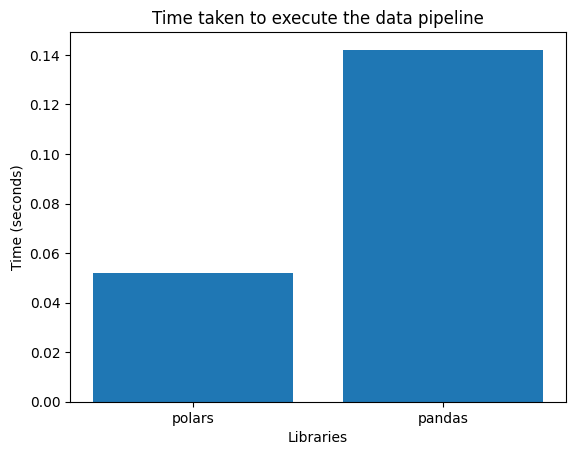

In [22]:
plt.bar(['polars', 'pandas'], [po, pa])
plt.xlabel('Libraries')
plt.ylabel('Time (seconds)')
plt.title('Time taken to execute the data pipeline')